In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import zscore

# Configurando estilos
sns.set(style="whitegrid")
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
directory = '..\\data\\processed'
parquet_file = [file for file in os.listdir(directory) if file.endswith('.parquet')][0]

In [3]:
parquet_dir = os.path.join(directory, parquet_file)
print(parquet_dir)

..\data\processed\concatenated_dfs.parquet


In [4]:
df = pd.read_parquet(parquet_dir)

# Objetivos da análise

## 1 Ver condição dos dados:
1. Nulos e faltantes - Done
1. Tipo dos dados - Done

# 1. Condição dos dados
## Nulos e faltantes

In [5]:
df.head(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,None,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,None,None,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",None,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,None,Alexander Peartree,None,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [6]:
for column in df.columns:
    nan_rows = round((df[column].isna().sum()/df.shape[0])*100,2).astype(str)+'%' # type: ignore
    print(f"Column name: {column} has {nan_rows} of NaN values")

Column name: country has 0.02% of NaN values
Column name: description has 0.0% of NaN values
Column name: designation has 29.62% of NaN values
Column name: points has 0.0% of NaN values
Column name: price has 8.08% of NaN values
Column name: province has 0.02% of NaN values
Column name: region_1 has 16.49% of NaN values
Column name: region_2 has 60.32% of NaN values
Column name: taster_name has 63.07% of NaN values
Column name: taster_twitter_handle has 64.84% of NaN values
Column name: title has 53.73% of NaN values
Column name: variety has 0.0% of NaN values
Column name: winery has 0.0% of NaN values


#### Checking data integrity
* Is there any difference between region_1 and region_2 values? - Done
* Rows with no price have at least values of variety or title for later input and treatment? - Done
* The number of taster_name that is NaN came from the 150k dataset? - Useless information, probably we won't be using at the recommendation system
* Which rows has title blank? There is any other information from there? - Done

##### Difference between region_1 and region_2

In [7]:
print(f"Region 1 has {df.region_1.nunique()} unique values")
print(f"Region 2 has {df.region_2.nunique()} unique values")

Region 1 has 1332 unique values
Region 2 has 18 unique values


In [8]:
df[~df['region_2'].isna()].shape[0]

111464

In [9]:
df.loc[(df['region_1']!= df['region_2'] ) & (df['region_2'].notnull()), ['region_1','region_2']]

,region_1,region_2
10,Napa Valley,Napa
12,Alexander Valley,Sonoma
21,Oregon,Oregon Other
23,Paso Robles,Central Coast
25,Sonoma Coast,Sonoma
...,...,...
280860,Santa Ynez Valley,Central Coast
280863,California,California Other
280867,California,California Other
280885,Anderson Valley,Mendocino/Lake Counties


It looks like the values are not the same as region_1, sice it has 100k non null values with different descriptions as region_1

##### NaN Price rows 

In [10]:
df.price.isna().sum()

22691

In [11]:
df_temp = df[df['price'].isna()]
df_temp.sample(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
153116,Italy,This is a thick and succulent dessert wine wit...,Passito 500ml,88,NaN,Veneto,Custoza,None,None,None,None,White Blend,Cantina Caorsa
151096,France,91-93. Barrel sample. Showing the acidity and ...,Barrel Sample,92,NaN,Bordeaux,Pessac-Léognan,None,None,None,None,Bordeaux-style Red Blend,Château Malartic-Lagravière
205664,France,"87–89. Barrel sample. Big, ripe and fruity, th...",Barrel Sample,88,NaN,Bordeaux,Margaux,None,None,None,None,Bordeaux-style Red Blend,Château Siran
205967,France,92–94. Barrel sample. While initially severe w...,Barrel Sample,93,NaN,Bordeaux,Pauillac,None,None,None,None,Bordeaux-style Red Blend,Château Duhart-Milon
21184,France,"92-94 Very structured wine, its fruit tannins ...",Barrel sample,93,NaN,Bordeaux,Margaux,None,Roger Voss,@vossroger,Château Siran 2010 Barrel sample (Margaux),Bordeaux-style Red Blend,Château Siran


In [12]:
for column in df.columns:
    nan_rows = round((df_temp[column].isna().sum()/df_temp.shape[0])*100,2).astype(str)+'%' # type: ignore
    print(f"Column name: {column} has {nan_rows} of NaN values")

Column name: country has 0.02% of NaN values
Column name: description has 0.0% of NaN values
Column name: designation has 26.93% of NaN values
Column name: points has 0.0% of NaN values
Column name: price has 100.0% of NaN values
Column name: province has 0.02% of NaN values
Column name: region_1 has 17.14% of NaN values
Column name: region_2 has 97.94% of NaN values
Column name: taster_name has 68.06% of NaN values
Column name: taster_twitter_handle has 68.27% of NaN values
Column name: title has 60.35% of NaN values
Column name: variety has 0.0% of NaN values
Column name: winery has 0.0% of NaN values


Looking for the rows that has no price, we have all of them with variety, winery and points value. In that case we could estimate the price based on [Winery, Variet, and Points values]. Its a guarantee that we can use all of the 22k rows with null prices 

##### Title NaN rows

In [13]:
df.title.isna().sum()

150930

In [14]:
df_temp = df[df['title'].isna()]
df_temp.sample(5)

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
246629,France,"This is so closed up at the moment, all minera...",Bougros Grand Cru,93,60.0,Burgundy,Chablis,None,None,None,None,Chardonnay,Jean-Marc Brocard
269078,US,Not very pleasant now due to the sharpness and...,Reserve,91,150.0,California,Oakville,Napa,None,None,None,Cabernet Sauvignon,Groth
250119,US,"Simple and soft, this dry red blend has sweet-...",Hermanas Cuvée,82,32.0,California,Santa Barbara County,Central Coast,None,None,None,Red Blend,Tres Hermanas
138623,Italy,"Aromas of rose petals, blue flower and ripe be...",Quarantacinque45 Ronchi,88,48.0,Piedmont,Barbaresco,None,None,None,None,Nebbiolo,Rattalino
132140,US,"Damp earth and forest floor mark this wine, a ...",La Masía Don Miguel Vineyard,87,44.0,California,Russian River Valley,Sonoma,None,None,None,Pinot Noir,Marimar Estate


In [15]:
for column in df.columns:
    nan_rows = round((df_temp[column].isna().sum()/df_temp.shape[0])*100,2).astype(str)+'%' # type: ignore
    print(f"Column name: {column} has {nan_rows} of NaN values")

Column name: country has 0.0% of NaN values
Column name: description has 0.0% of NaN values
Column name: designation has 30.3% of NaN values
Column name: points has 0.0% of NaN values
Column name: price has 9.07% of NaN values
Column name: province has 0.0% of NaN values
Column name: region_1 has 16.6% of NaN values
Column name: region_2 has 59.62% of NaN values
Column name: taster_name has 100.0% of NaN values
Column name: taster_twitter_handle has 100.0% of NaN values
Column name: title has 100.0% of NaN values
Column name: variety has 0.0% of NaN values
Column name: winery has 0.0% of NaN values


As it has all the taster_name and twitter values NaN, we can assume that most of them came from the 150k dataset. No need for futher investigation

#


## Tipos dos dados

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280901 entries, 0 to 280900
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   country                280833 non-null  object 
 1   description            280901 non-null  object 
 2   designation            197701 non-null  object 
 3   points                 280901 non-null  int64  
 4   price                  258210 non-null  float64
 5   province               280833 non-null  object 
 6   region_1               234594 non-null  object 
 7   region_2               111464 non-null  object 
 8   taster_name            103727 non-null  object 
 9   taster_twitter_handle  98758 non-null   object 
 10  title                  129971 non-null  object 
 11  variety                280900 non-null  object 
 12  winery                 280901 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 27.9+ MB


For me is okay, don't need any other treatment for now. Futher, when doing feature engineering, we'll scale, encode variables and gather information from description

## 2 Distribuição dos vinhos com relação a:
1. Pontos e Preço - TbD
1. País e região - TbD
1. Variedade - TbD
1. Winery - TbD
1. Designation - TbD
1. Avaliadores - TbD


## Pontos e preços

In [17]:
#Olhando a distribuição das duas variáveis numéricas que temos disponíveis
df.describe()

,points,price
count,280901.000000,258210.000000
mean,88.146934,34.177162
std,3.151528,38.611708
min,80.000000,4.000000
25%,86.000000,16.000000
50%,88.000000,25.000000
75%,90.000000,40.000000
max,100.000000,3300.000000


* Valores de pontos distribuiídos entre 80 e 100, com pequena variação
* Preços possuem maior variação e uma grande diferença entre a média e valor máximo (possível incidência de outliers)

### Distribuição dos pontos

* Olhar para as distribuição dos pontos, quartis e quantidades

c:\Users\lci734\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lci734\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lci734\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


C:\Users\lci734\AppData\Local\Temp\ipykernel_4340\66827877.py:28: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


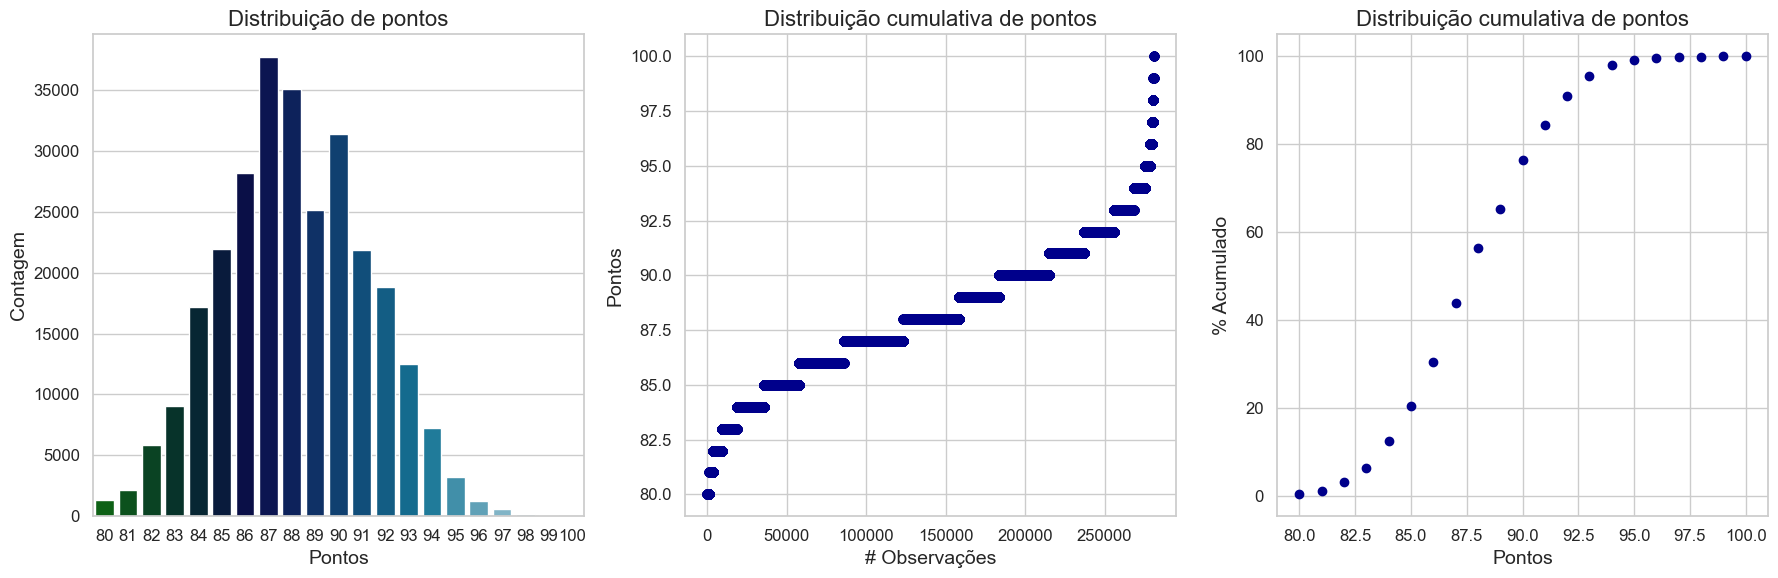

In [18]:

# Calcular a soma acumulada
cum_sum = df.groupby('points').agg(frequency = ('points', 'count')).reset_index()
total = cum_sum.frequency.sum()
cum_sum['cumulative_sum'] = round((cum_sum['frequency'].cumsum()/len(df))*100,2)


#Plotagem
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize= (18,6))

#Primeiro plot - histograma de pontos
sns.countplot(data = df, x = 'points', palette = 'ocean', ax = axes[0])
axes[0].set_title('Distribuição de pontos')
axes[0].set_xlabel('Pontos')
axes[0].set_ylabel('Contagem')
plt.tight_layout()

#Segundo plot - Preços vs nota
axes[1].scatter(data = df.sort_values(by='points', ascending=True), x = range(df.shape[0]) , y = 'points',color = 'darkblue')
axes[1].set_title('Distribuição cumulativa de pontos')
axes[1].set_xlabel('# Observações')
axes[1].set_ylabel('Pontos')

# Terceiro plot
axes[2].scatter(data = cum_sum, x = 'points', y= 'cumulative_sum', color = 'darkblue')
axes[2].set_title('Distribuição cumulativa de pontos')
axes[2].set_xlabel('Pontos')
axes[2].set_ylabel('% Acumulado')
plt.tight_layout()
plt.show()

### Variedade

* Olhar para distribuição de vinhos com maiores frequencias
* Distribuição dos vinhos mais avaliados
* Distribuição dos pontos distribuidos ao longo das variedades

In [19]:
count = df.groupby('variety').agg(count_column=('variety', 'count')).reset_index().sort_values(by = 'count_column', ascending= False)[:20]

In [20]:
count

,variety,count_column
476,Pinot Noir,27563
132,Chardonnay,26235
84,Cabernet Sauvignon,22272
510,Red Blend,19008
64,Bordeaux-style Red Blend,14262
553,Sauvignon Blanc,11287
516,Riesling,10713
604,Syrah,9967
350,Merlot,8172
751,Zinfandel,6513


c:\Users\lci734\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lci734\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\lci734\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


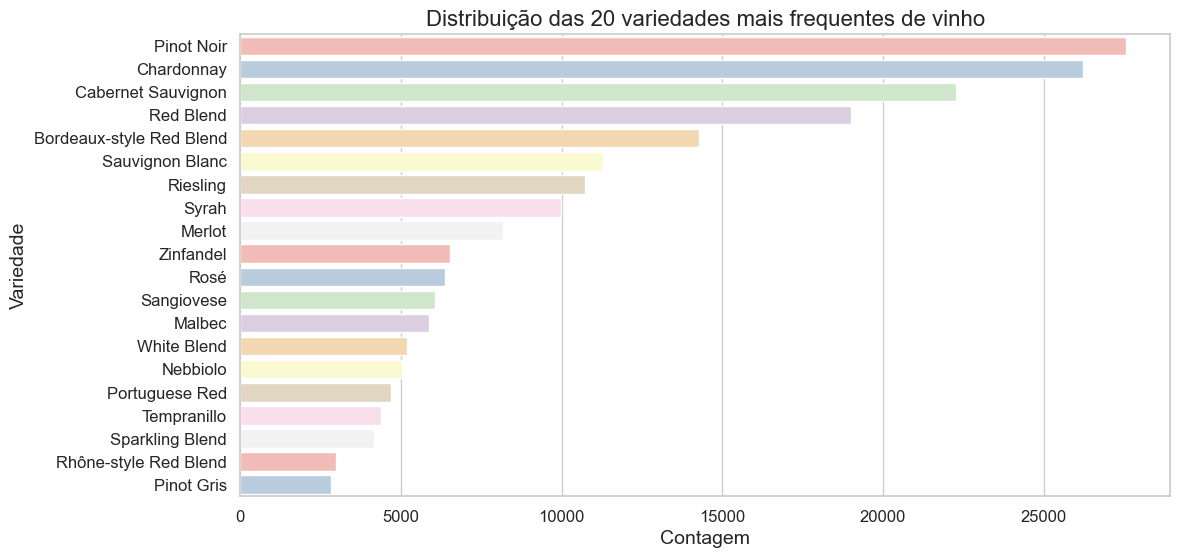

In [21]:

plt.figure(figsize=(12,6))
plt.title('Distribuição das 20 variedades mais frequentes de vinho')
sns.barplot(data = count, x = 'count_column', y = 'variety', palette = 'Pastel1', orient = 'h')
plt.xlabel('Contagem')
plt.ylabel('Variedade');


Vinho uva pinot noir é a uva mais vezes avaliada, sendo ela uma uva tinta

### País e região

##### Distribuição geral

In [74]:
regions_1 = df.groupby('region_1')['region_1'].value_counts().sort_values(ascending=False).reset_index()
regions_1['index']=regions_1.index

country = df.groupby('country')['country'].value_counts().sort_values(ascending=False).reset_index()
country['index']=country.index

In [75]:
print('region_1', '\n', regions_1.describe())
print('country', '\n', country.describe())

region_1 
               count       index
count   1332.000000  1332.00000
mean     176.121622   665.50000
std      635.988250   384.65959
min        1.000000     0.00000
25%        5.000000   332.75000
50%       22.000000   665.50000
75%       99.000000   998.25000
max    10689.000000  1331.00000
country 
                count     index
count      50.000000  50.00000
mean     5616.660000  24.50000
std     18349.211248  14.57738
min         1.000000   0.00000
25%        12.000000  12.25000
50%       106.000000  24.50000
75%      1296.250000  36.75000
max    116901.000000  49.00000


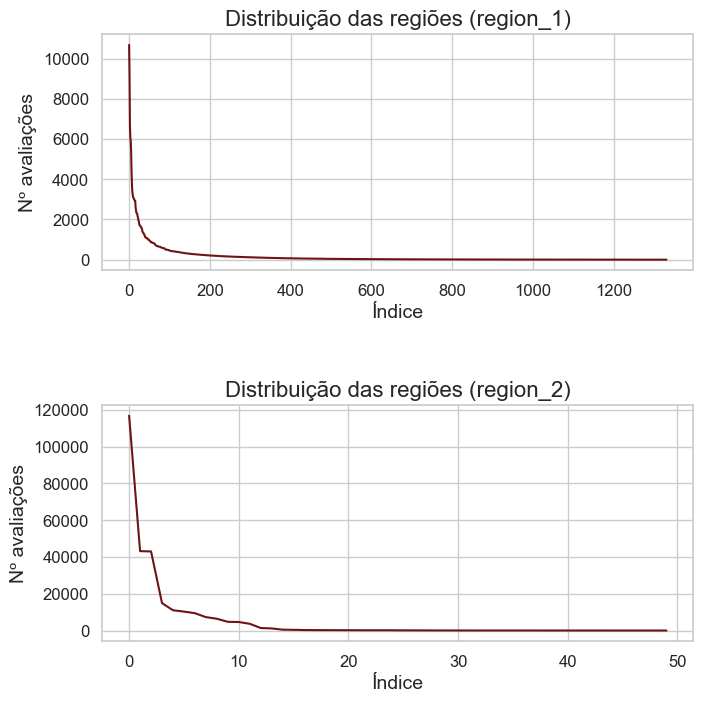

In [76]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(8,8))

x1 = regions_1.index.values
y1 = regions_1['count'].values

x2 = country.index.values
y2 = country['count'].values

ax[0].plot(x1, y1, c='#701313')
ax[1].plot(x2, y2, c='#701313')

for i in range(0,2):
    ax[i].set_title(f'Distribuição das regiões (region_{i+1})')
    ax[i].set_xlabel('Índice')

    ax[i].set_ylabel('Nº avaliações')

fig.tight_layout(pad=3)

plt.show()

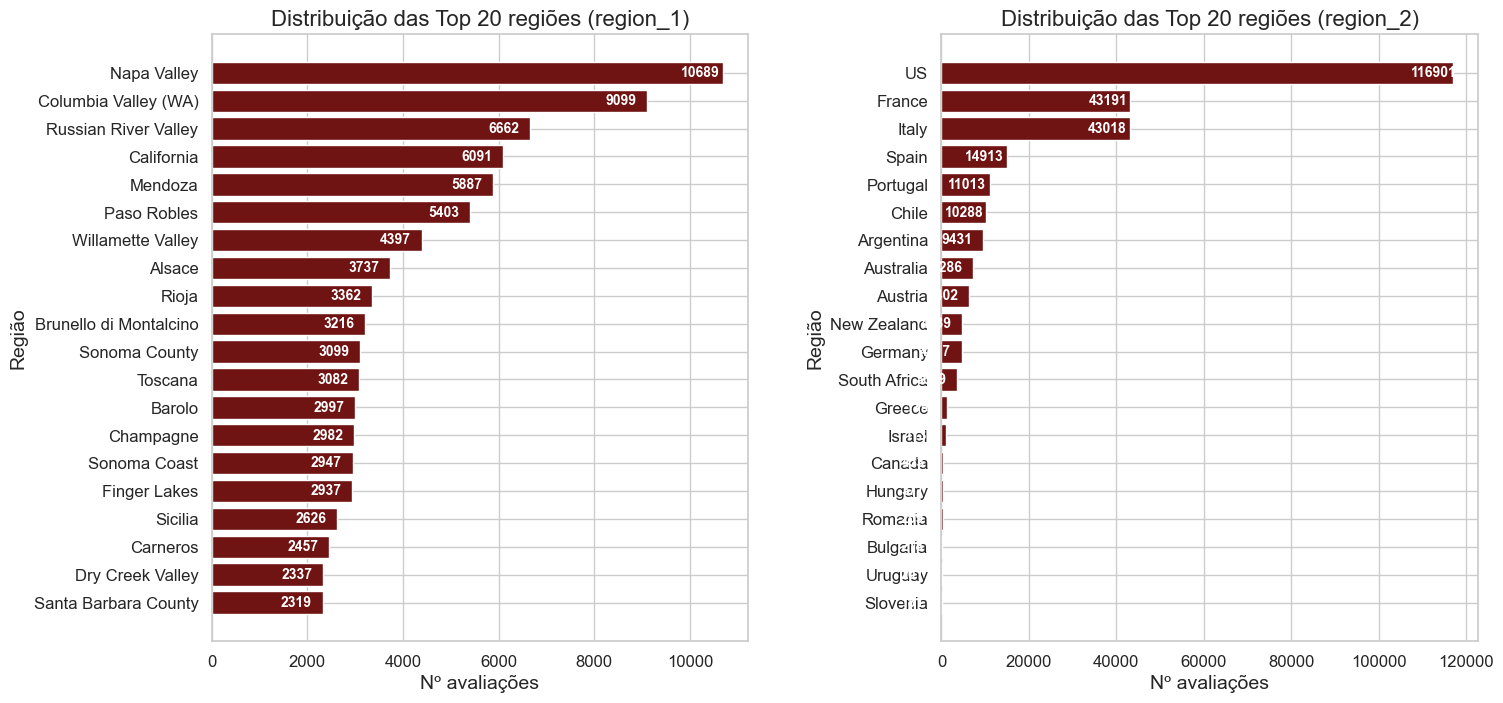

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

def labels(array, ax):
    for i, value in enumerate(array):
        ax[ax].set_text(s=value, x=array[i], y=i)

x1 = regions_1['count'].values[0:20]
y1 = regions_1['region_1'].values[0:20]

x2 = country['count'].values[0:20]
y2 = country['country'].values[0:20]

bars1 = ax[0].barh(y1, x1, color='#701313')
bars2 = ax[1].barh(y2, x2, color='#701313')

for i in range(0,2):
    ax[i].set_title(f'Distribuição das Top 20 regiões (region_{i+1})')
    ax[i].set_ylabel('Região')
    ax[i].set_xlabel('Nº avaliações')
    ax[i].invert_yaxis()    

fig.tight_layout(pad=3)

ax[0].bar_label(bars1 , x1, padding=-30, fontsize=10, color='white', fontweight='bold', label_type='edge')
ax[1].bar_label(bars2 , x2, padding=-30, fontsize=10, color='white', fontweight='bold', label_type='edge')

plt.show()

##### Verificando se a distribuição das regiões segue uma distribuição normal

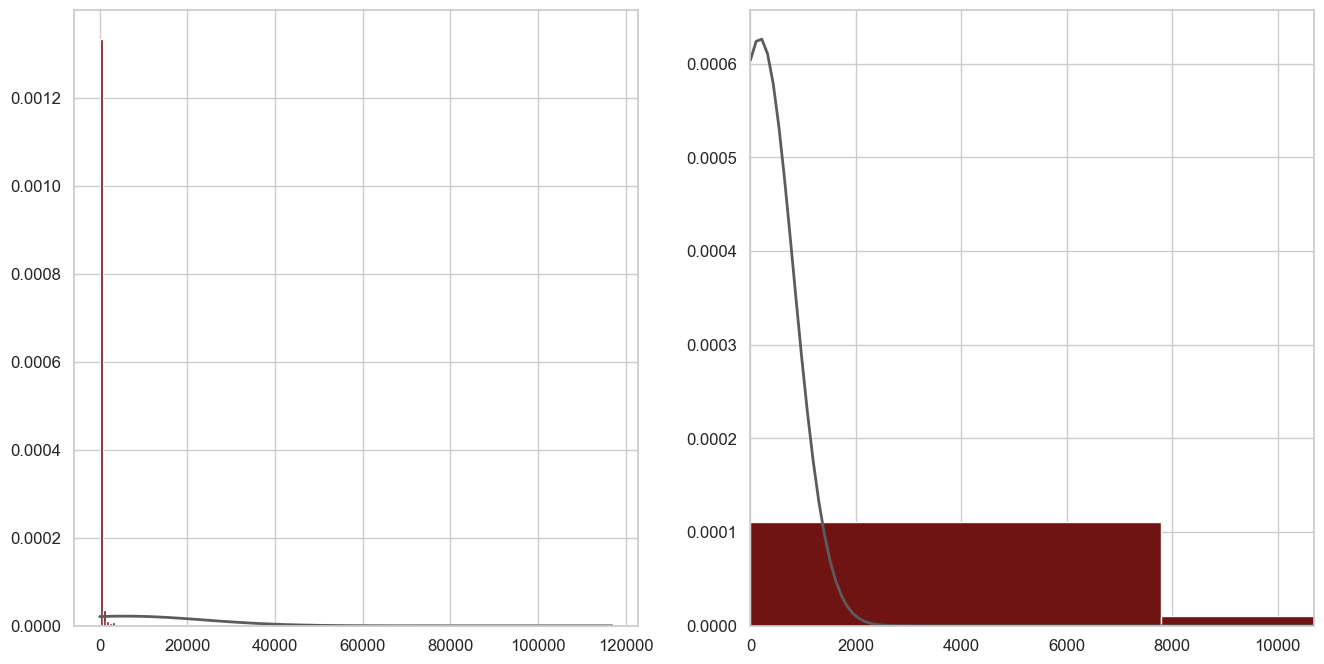

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(16,8))

x1 = regions_1['count'].values
x2 = country['count'].values

# Plotting histogram
ax[0].hist(x1, bins=15, color='#701313', density=True)
ax[1].hist(x2, bins=15, color='#701313', density=True)

# Removing outliers
z_scores = np.abs(zscore(regions_1['count']))
threshold = 3
regions = regions_1[z_scores <= threshold]
x2 = regions_1['count'].values

# Removing outliers
z_scores = np.abs(zscore(regions_2['count']))
threshold = 3
regions = country[z_scores <= threshold]
x1 = country['count'].values

# Normal distribuition params
mean, std = norm.fit(x1)
xmin = 0
xmax = x1.max()
plt.xlim(xmin, xmax)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
# Plotting normal distribuition
ax.flat[0].plot(x, p, color='#5C5C5C', linewidth=2)

# Normal distribuition params
mean, std = norm.fit(x2)
xmin = 0
xmax = x2.max()
plt.xlim(xmin, xmax)
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
# Plotting normal distribuition
ax.flat[1].plot(x, p, color='#5C5C5C', linewidth=2)
plt.show()

### Winery

In [27]:
winery = df.groupby('winery')['winery'].value_counts().sort_values(ascending=False).reset_index()
winery['index']=winery.index

In [28]:
winery.describe()

,count,index
count,19186.000000,19186.000000
mean,14.640936,9592.500000
std,26.927493,5538.665468
min,1.000000,0.000000
25%,2.000000,4796.250000
50%,5.000000,9592.500000
75%,15.000000,14388.750000
max,585.000000,19185.000000


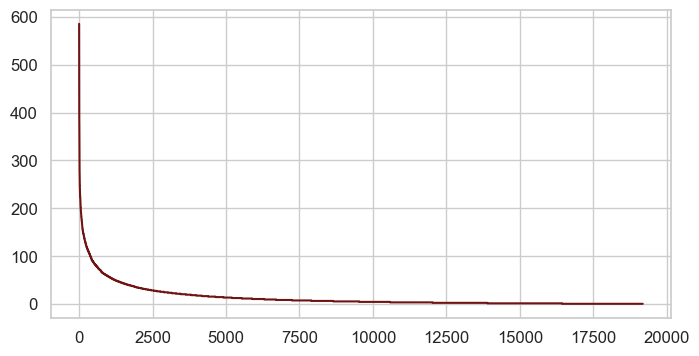

In [29]:
fig, ax = plt.subplots(figsize=(8, 4))

x = winery.index.values
y = winery['count'].values

ax.plot(x, y, c='#701313')

plt.show()

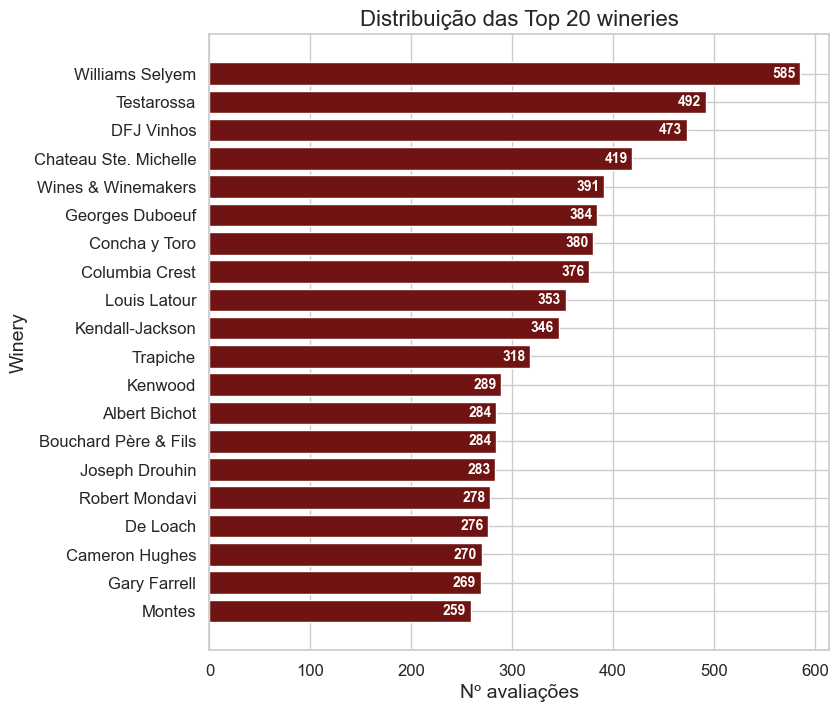

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))

x = winery['winery'].values[0:20]
y = winery['count'].values[0:20]

bars = ax.barh(x, y, color='#701313')

ax.set_title(f'Distribuição das Top 20 wineries')
ax.set_ylabel('Winery')
ax.set_xlabel('Nº avaliações')
ax.invert_yaxis() 

ax.bar_label(bars , y, padding=-20, fontsize=10, color='white', fontweight='bold', label_type='edge')

plt.show()

### Designation

In [31]:
designation = df.groupby('designation')['designation'].value_counts().sort_values(ascending=False).reset_index()
designation['index']=designation.index

In [32]:
designation.describe()

,count,index
count,47239.000000,47239.00000
mean,4.185122,23619.00000
std,34.124760,13636.86902
min,1.000000,0.00000
25%,1.000000,11809.50000
50%,2.000000,23619.00000
75%,4.000000,35428.50000
max,4761.000000,47238.00000


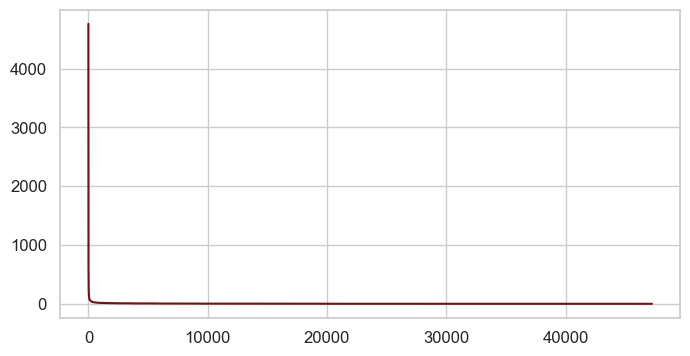

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))

x = designation.index.values
y = designation['count'].values

ax.plot(x, y, c='#701313')

plt.show()

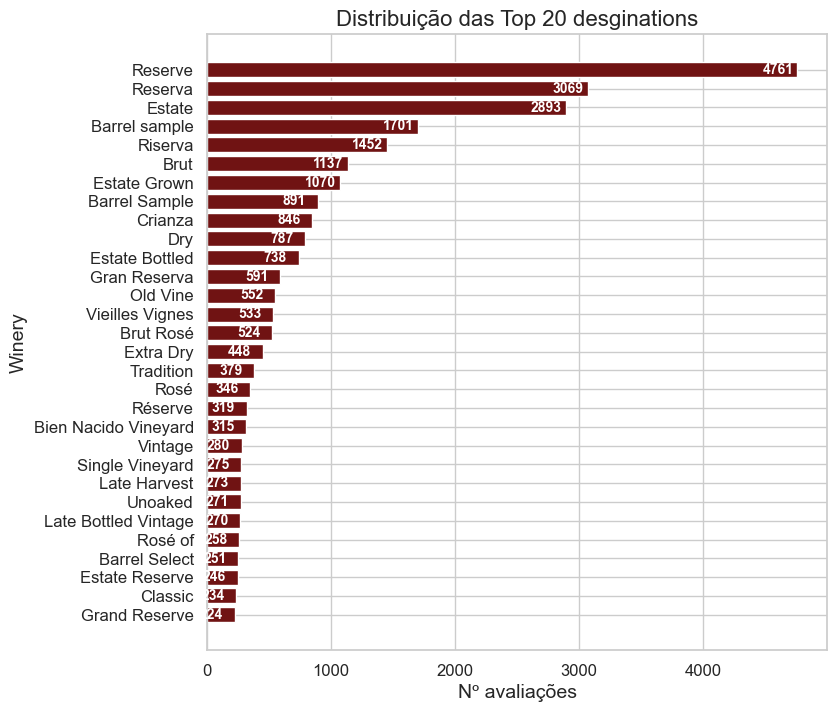

In [43]:
fig, ax = plt.subplots(figsize=(8, 8))

x = designation['designation'].values[0:30]
y = designation['count'].values[0:30]

bars = ax.barh(x, y, color='#701313')

ax.set_title(f'Distribuição das Top 20 desginations')
ax.set_ylabel('Winery')
ax.set_xlabel('Nº avaliações')
ax.invert_yaxis() 

ax.bar_label(bars , y, padding=-25, fontsize=10, color='white', fontweight='bold', label_type='edge')

plt.show()

### Avaliadores

In [35]:
taster_name = df.groupby('taster_name')['taster_name'].value_counts().sort_values(ascending=False).reset_index()
taster_name['index']=taster_name.index

In [36]:
taster_name.describe()

,count,index
count,19.000000,19.000000
mean,5459.315789,9.000000
std,6492.162275,5.627314
min,6.000000,0.000000
25%,502.500000,4.500000
50%,4177.000000,9.000000
75%,7932.000000,13.500000
max,25514.000000,18.000000


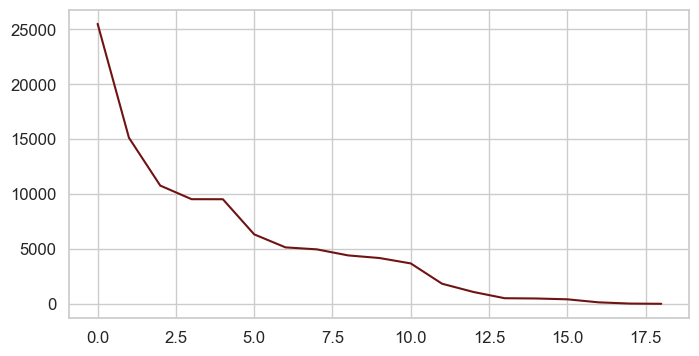

In [37]:
fig, ax = plt.subplots(figsize=(8, 4))

x = taster_name.index.values
y = taster_name['count'].values

ax.plot(x, y, c='#701313')

plt.show()

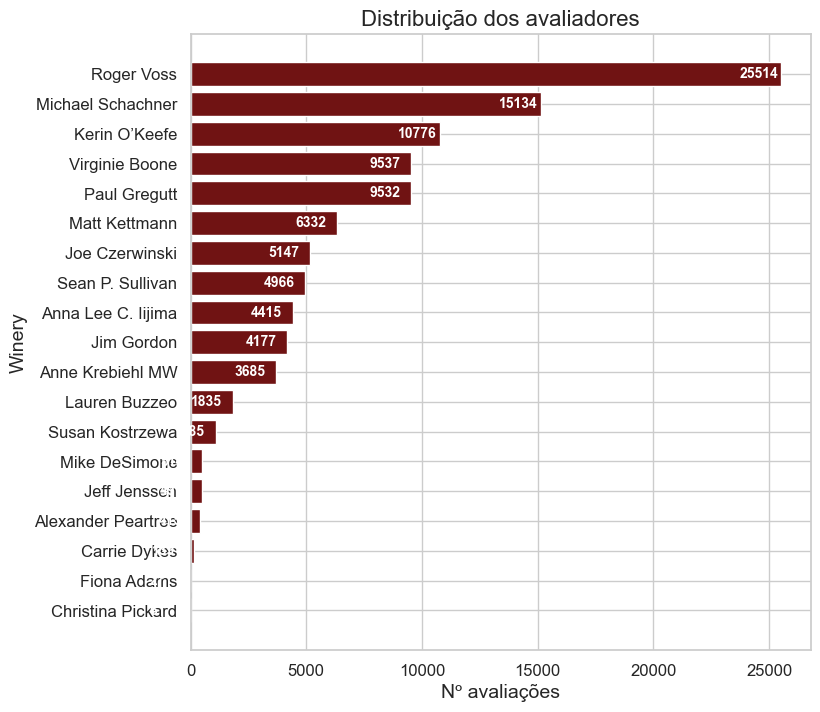

In [38]:
fig, ax = plt.subplots(figsize=(8, 8))

x = taster_name['taster_name'].values
y = taster_name['count'].values

bars = ax.barh(x, y, color='#701313')

ax.set_title(f'Distribuição dos avaliadores')
ax.set_ylabel('Winery')
ax.set_xlabel('Nº avaliações')
ax.invert_yaxis() 

ax.bar_label(bars , y, padding=-30, fontsize=10, color='white', fontweight='bold', label_type='edge')

plt.show()

##### Visualizando a distribuição das notas por avaliador

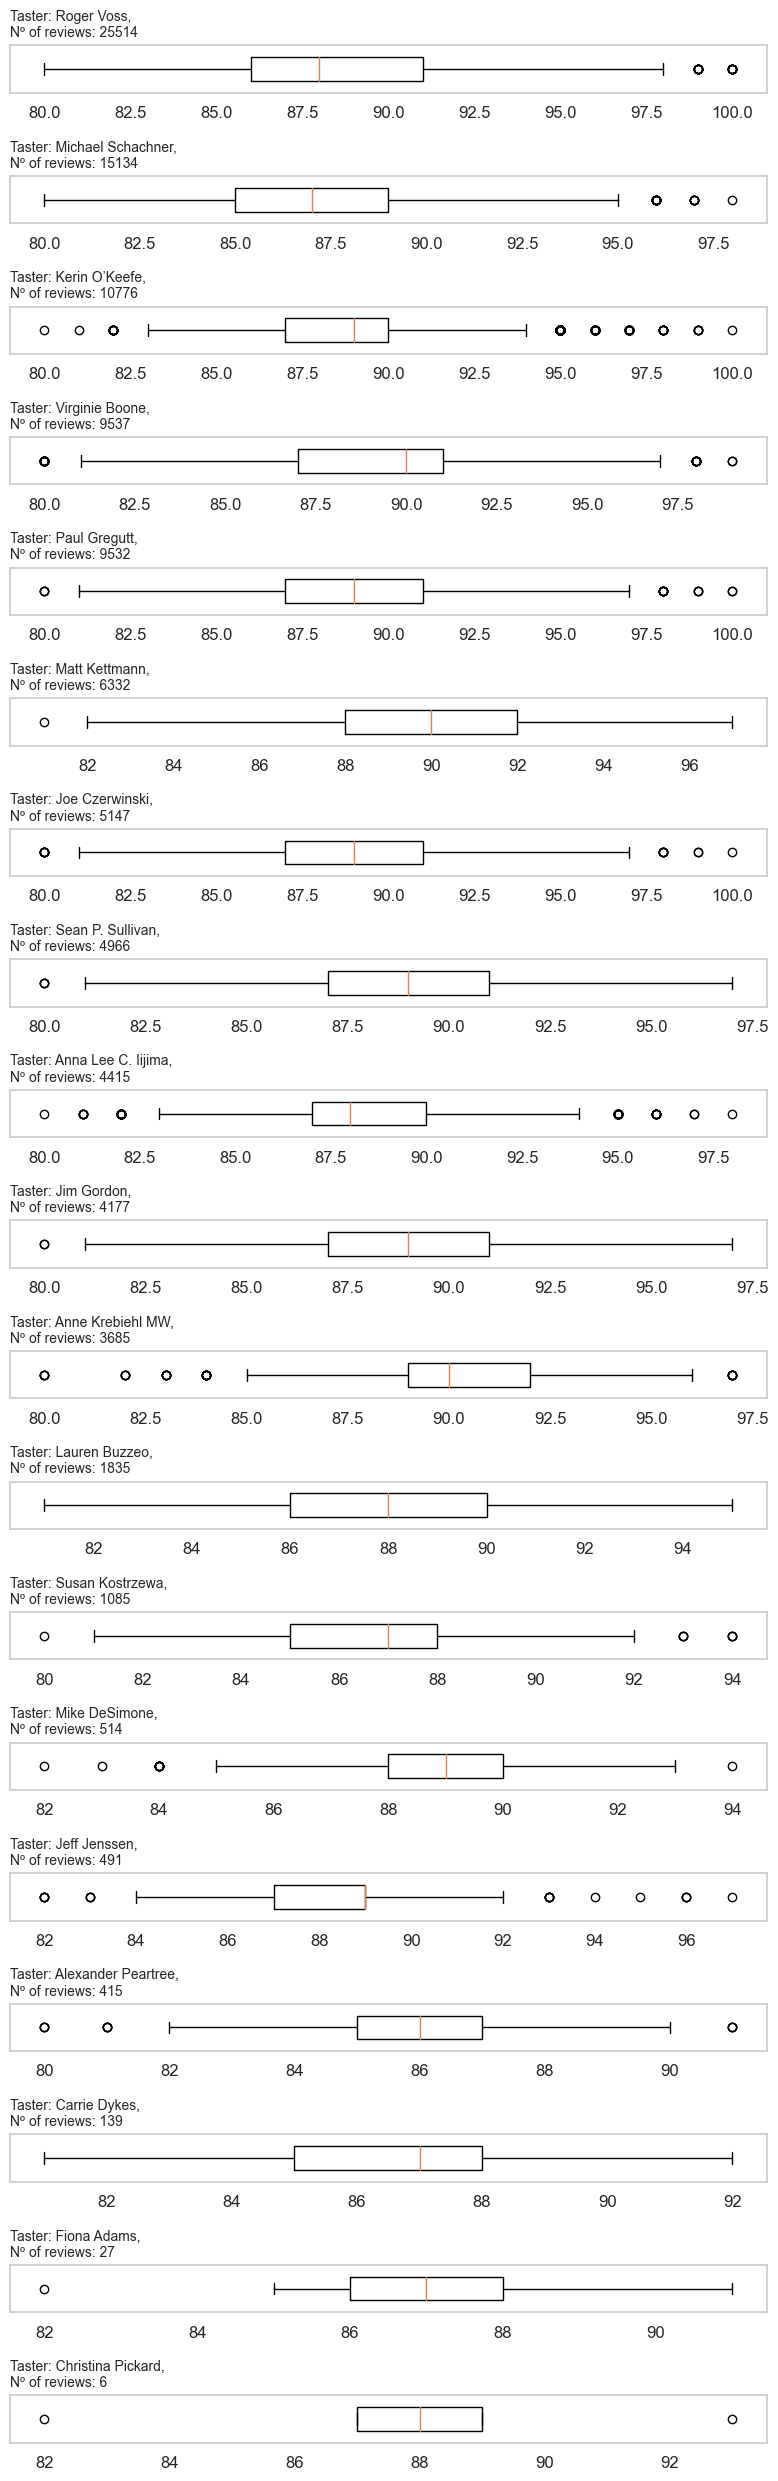

In [39]:
fig, ax = plt.subplots(nrows=19, figsize=(8,25))

labels = taster_name.taster_name.values
data = df[['taster_name', 'points']]

for i, taster in enumerate(labels):
    values = data.loc[data.taster_name == taster].points.values
    ax[i].boxplot(values, vert=False, widths=0.5)
    ax[i].yaxis.grid(False)
    ax[i].xaxis.grid(False)
    ax[i].set_yticklabels([])
    #ax[i].set_xticklabels([])
    
    n_reviews = taster_name.loc[taster_name.taster_name == taster]['count'].values[0]
    ax[i].set_title(f'Taster: {taster}, \nNº of reviews: {n_reviews}', loc='left', fontsize=10)

fig.tight_layout(pad=1)

plt.show()

###